**Zgony w grupach wiekowych w województwach lub do wyboru kod regionu**




Narysować zgony 2000-2021 w Polsce tygodniowo
w rozbiciu na:
* grupy wiekowe,
* płeć.

Dane z:

https://ec.europa.eu/eurostat/web/population-demography-migration-projections/data/database?node_code=demomwk

Plik dla państw:

https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/demo_r_mwk_05.tsv.gz

Plik dla wojawództw:

https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/demo_r_mwk2_05.tsv.gz

Obadać: https://pypi.org/project/eurostat/

Ściąganie prosto z Eurostatu!

* **Plot podświetla ostatnią linię, a powinno być do wyboru**


* Zaktualizować dane
* Policzyć zgony 2020 jako procent regresji z trendem
    * Trendy są różne dla różnych grup wiekowych i niemonotoniczne
    * Liczyć trend jako zmiany średniej rocznej z upływem lat
        * Spłaszczyć wykresy roczne, odejmując trend
        * Policzyć średnie z tygodni po wszystkich latach (po odjęciu trendu)
        * Zobaczyć na ile jesień 2020 odbiega od tak policzonej średniej
    * Uwaga! Trend kończyłby się na roku 2019
        * Piotr Pokarowski liczy trend jakoś inaczej, do ostatka
        * Robi regresję na rok 2020
    * Zwalidować: Dane dla 2020 będą odstawać od trendu przewidywanego dla 2020. Ale porównać, jak bardzo dane 2019 odstają od trendu dofitowanego dla 2019.
        * Na oko, trend jest przekrzywiony, bo minimum sezonowe jest w 30. tygodniu, a nie w 27.
* Wybieranie grup wiekowych też za pomocą pivot?


Funkcja fitowana do trendu demograficznego:

$ f(x,y)= a x^2 + b x+  c +  A (y-y_0)^2  $

$x$: Lata.

$y$: Tygodnie.

$y_0$: Minimum lub maksimum sezonowości. Jeśli jest sezonowość, to minimum lub maksimum obserwujemy w przybliżeniu środku roku.

W niektórych przypadkach fituję pełną funkcję $f(x,y)$ z parametrami fitowania: $a$, $b$, $c$, $A$, $y_0$.

W innych lepiej fituje się funkcja liniowa w latach. Wtedy ustawiam $a=0$ i parametrami fitowania są:  $b$, $c$, $A$, $y_0$.

W jeszcze innych przypadkach lepiej fituje się funkcja płaska sezonowo (w tygodniach). Wtedy ustawiam $A =0$ i parametrami fitowania są: $a$, $b$, $c$.

Z kolei w niektórych przypadkach najlepiej fituje się funkcja liniowa w latach i płaska sezonowo. Wtedy ustawiam $a=0$ i $A =0$, a parametrami fitowania są:  $b$, $c$.

**Uwaga, jak to zmienić? Sezonowość powinna być proporcjonalna do liczby zgonów**
**Chyba za dużo parametrów fitowania. Uprościć wzory**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from scipy import optimize

# https://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python
def list_to_regex_string(str_list):
    regex_string = r"(?=(\b" + '\\b|\\b'.join(str_list) + r"\b))"
    return regex_string 


# https://stackoverflow.com/questions/25936746/create-a-function-decorator-that-logs-arguments
def logger(prefix, show_first_argument=False):
    def decorate(f):
        def wrapper(*args, **kwargs):
            if show_first_argument:
                print(prefix, args[0])
            else:
                print(prefix)
            cr = f(*args, **kwargs)
            return cr
        return wrapper
    return decorate

@logger("Read file:",show_first_argument=True)
def read_dataframe(file, sep='\t'):
    df = pd.read_csv(file,low_memory=False, sep=sep)
    return df


def select_country(df, country_code):
    return df[df.iloc[:,0].str.contains(","+country_code)]
    
def replace_with_nan(df):
    df.replace(': ' , np.nan, inplace=True)
    return

@logger("Removing \'p\' postscript (\'provisionary\')")
def clean_p(df):
    df.replace(' p' , '', inplace=True, regex=True)
    return

def to_numbers(df):
    numeric_columns = df.columns[1:]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce', axis=1)
    return







# def split_column(df, column_label):
#     new_column_labels = column_label.split(',')
#     df[column_label ]= df[column_label ].astype(str) 
#     df[new_column_labels ]= df[column_label ].str.split(',',expand=True)
#     return

# def move_split_columns_to_front(df, column_label):
#     new_column_labels = column_label.split(',')
#     tmp = df[new_column_labels] 
#     df.drop(labels=new_column_labels , axis=1,inplace = True)
#     df.drop(labels=[column_label ] , axis=1,inplace = True)
#     for i in reversed(range(0,4)):
#         df.insert(0, new_column_labels[i] , tmp.iloc[:,i]) 
#     return

# def split_first_column(df):
#     column_label = 'age,sex,unit,geo\\time'
    
#     split_column(df, column_label)
#     move_split_columns_to_front(df, column_label)
#     return

def first_row_to_header(df):
    df.rename(columns=df.iloc[0], inplace=True)
    df.drop('age,sex,unit,geo\\time', inplace=True)
    return df

def reverse_rows(df):
    df = df.iloc[::-1]
    return df

# To działa tylko dla Polski, a powinno dla dowolnego kraju
def sort_columns(df):
    list = ['TOTAL,F,NR,PL', 'TOTAL,M,NR,PL', 'TOTAL,T,NR,PL', 'UNK,F,NR,PL',
       'UNK,M,NR,PL', 'UNK,T,NR,PL', 
        'Y_LT5,F,NR,PL', 'Y_LT5,M,NR,PL', 'Y_LT5,T,NR,PL',
        'Y5-9,F,NR,PL', 'Y5-9,M,NR,PL',
       'Y5-9,T,NR,PL',
       'Y10-14,F,NR,PL', 'Y10-14,M,NR,PL',
       'Y10-14,T,NR,PL', 
       'Y15-19,F,NR,PL', 'Y15-19,M,NR,PL', 'Y15-19,T,NR,PL',
       'Y20-24,F,NR,PL', 'Y20-24,M,NR,PL', 'Y20-24,T,NR,PL', 
       'Y25-29,F,NR,PL',
       'Y25-29,M,NR,PL', 'Y25-29,T,NR,PL', 'Y30-34,F,NR,PL', 'Y30-34,M,NR,PL',
       'Y30-34,T,NR,PL', 'Y35-39,F,NR,PL', 'Y35-39,M,NR,PL', 'Y35-39,T,NR,PL',
       'Y40-44,F,NR,PL', 'Y40-44,M,NR,PL', 'Y40-44,T,NR,PL', 'Y45-49,F,NR,PL',
       'Y45-49,M,NR,PL', 'Y45-49,T,NR,PL',  'Y50-54,F,NR,PL', 'Y50-54,M,NR,PL', 'Y50-54,T,NR,PL',
       'Y55-59,F,NR,PL', 'Y55-59,M,NR,PL', 'Y55-59,T,NR,PL', 'Y60-64,F,NR,PL',
       'Y60-64,M,NR,PL', 'Y60-64,T,NR,PL', 'Y65-69,F,NR,PL', 'Y65-69,M,NR,PL',
       'Y65-69,T,NR,PL', 'Y70-74,F,NR,PL', 'Y70-74,M,NR,PL', 'Y70-74,T,NR,PL',
       'Y75-79,F,NR,PL', 'Y75-79,M,NR,PL', 'Y75-79,T,NR,PL', 'Y80-84,F,NR,PL',
       'Y80-84,M,NR,PL', 'Y80-84,T,NR,PL', 'Y85-89,F,NR,PL', 'Y85-89,M,NR,PL',
       'Y85-89,T,NR,PL', 'Y_GE90,F,NR,PL', 'Y_GE90,M,NR,PL', 'Y_GE90,T,NR,PL',
       ]
    return df.reindex(list, axis=1)


def make_age_groups_dict():
    age_groups_dict={
        0:'Y_LT5',
        5:'Y5-9',
        10:'Y10-14',
        15:'Y15-19',
        20:'Y20-24',
        25:'Y25-29',
        30:'Y30-34',
        35:'Y35-39',
        40:'Y40-44',
        45:'Y45-49',
        50:'Y50-54',
        55:'Y55-59',
        60:'Y60-64',
        65:'Y65-69',
        70:'Y70-74',
        75:'Y75-79',
        80:'Y80-84',
        85:'Y85-89',
        90:'Y_GE90' 
    }
    return age_groups_dict


def make_age_groups_verbose_dict():
    age_groups_verbose_dict={
        0:'< 5 years',
        5:'5-9 years',
        10:'10-14 years',
        15:'15-19 years',
        20:'20-24 years',
        25:'25-29 years',
        30:'30-34 years',
        35:'35-39 years',
        40:'40-44 years',
        45:'45-49 years',
        50:'50-54 years',
        55:'55-59 years',
        60:'60-64 years',
        65:'65-69 years',
        70:'70-74 years',
        75:'75-79 years',
        80:'80-84 years',
        85:'85-89 years',
        90:'> 90 years' 
    }
    return age_groups_verbose_dict


@logger("Cleaning data frame...")
def clean(df):
    replace_with_nan(df)
    clean_p(df)
    to_numbers(df)
#     split_first_column(df)
    df = df.transpose()
    first_row_to_header(df)
    df = reverse_rows(df)
#     df = sort_columns(df) # Nie robić tego, to bez sensu
    return df


# Funkcje poniżej powinny działać tylko na oczyszczonych dataframes: zrobić klasę clean_dataframe
def select_year(df, year_str):
    condition = df.index.str.contains('2020')
    return df[condition]

def select_all_age_groups_both_genders(df):
    return df.filter(regex='Y').filter(regex=',T')



# Zmienna globalna
# To powinien być element klasy
age_groups = make_age_groups_dict()
age_groups_verbose = make_age_groups_verbose_dict()



# https://www.programiz.com/python-programming/user-defined-exception
# define Python user-defined exceptions
class Error(Exception):
    """Base class for other exceptions"""
    pass

class ValueTooSmallError(Error):
    """Raised when the input value is too small"""
    pass


class ValueTooLargeError(Error):
    """Raised when the input value is too large"""
    pass


class ValueDoesNotFitAgeGroupSizeError(Error):
    """Raised when the value does not fit age group size"""
    pass



def select_single_age_group(df, years_min):
    return df.filter(regex=age_groups.get(years_min))

def age_groups_range_list(from_year, to_year, age_group_size=5, max_years=95):
    try:
        if from_year<0:
            raise ValueTooSmallError
        elif to_year>max_years:
            raise ValueTooLargeError
        elif from_year%age_group_size or to_year%age_group_size:
            raise ValueDoesNotFitAgeGroupSizeError    
        else:
            age_group_list = list(range(from_year, to_year, age_group_size))
    
    except ValueDoesNotFitAgeGroupSizeError:
        print("The value does not fit age group size")
    except ValueTooSmallError:
        print("The value is to small")
    except ValueTooLargeError:
        print("The value is to large")
    return age_group_list

def age_group_label_list(from_year, to_year, age_group_size=5, max_years=95):
    range_list = age_groups_range_list(from_year, to_year, age_group_size, max_years)
    labels=[age_groups[x] for x in range_list]
    return labels



def select_age_groups_list_by_labels(df, age_group_label_list):
    regex_str = list_to_regex_string(age_group_label_list)
    return df.filter(regex=regex_str )

def select_age_groups_by_range(df, from_year, to_year, age_group_size=5, max_years=95): 
    agll = age_group_label_list(from_year, to_year, age_group_size, max_years)
    return select_age_groups_list_by_labels(df, agll)


def make_year_week_columns(df):
    df['Year'] = pd.to_numeric(df.index.astype(str).str[0:4])
    df['Week'] = pd.to_numeric(df.index.astype(str).str[5:7])
    
    return df

def group_by_year(df):
    return make_year_week_columns(df).pivot(index='Week', columns='Year')

# def year_list(df):
#     return pd.unique(df['Year']).tolist()



# def df_list_by_year(df):
#     df_list=[]
#     for year in year_list(df):
#         df_list.append(df1.loc[df['Year'] == year])
#     return df_list


def select_gender(df, str):
    if str == 'T':
        df = df.filter(regex=',T')
    else:
        df = df.filter(regex=str)
    return df





import matplotlib as mpl
from typing import Any, NamedTuple


def exists_df(df):
    if not isinstance(df, type(None)):
        b=True
    else:
        b=False
    return b

# https://stackoverflow.com/a/43157792
class PlotOptions(NamedTuple):
    xlabel: str = None
    ylabel: str = None
    title: str=None
    legend: str=None
    cmap: mpl.colors.LinearSegmentedColormap = mpl.cm.Blues
    ylim: tuple=None
#     trend_df_exists: bool = None # Dokończyć to

        
        
def matplotlib_plot(df, dftrend = None):
    fig, ax = plt.subplots()
    df.plot(ax=ax)
    if exists_df(dftrend):
        dftrend['Trend 2020'].plot(ax=ax)
        dftrend['Trend 2021'].plot(ax=ax)
    return fig, ax



def set_matplotlib_plot_options(fig, ax, plot_options, dftrend=None):
    set_ticks(rotation=0)
    set_minor_ticks(ax)
    set_grid(ax)
    set_axes_labels(ax,plot_options)
    set_colors(ax, plot_options)
    set_last_line_thicker(ax, dftrend) # przenieść dftrend do plotoptions
    set_last_line_color(ax, dftrend)
    set_legend(plot_options)
    set_title(ax,plot_options)
    return

def plot_df(df, plot_options, dftrend=None):
    fig, ax = matplotlib_plot(df, dftrend)
    if plot_options.ylim: 
#         print(plot_options.ylim)
        ax.set_ylim(plot_options.ylim)
    set_matplotlib_plot_options(fig, ax, plot_options, dftrend)
    plt.show()
    ylim = ax.get_ylim()
    return fig, ylim

def set_legend(plot_options):
    if plot_options.legend:
        plt.legend(plot_options.legend, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return

def set_ticks(rotation):
    plt.xticks(rotation=rotation)
    return

def set_grid(ax):
    ax.xaxis.grid()
    ax.yaxis.grid()
    return

# Dać to do plot_options
def set_last_line_thicker(ax, dftrend):
    if exists_df(dftrend):
        ax.lines[-4].set_linewidth(4)
        ax.lines[-3].set_linewidth(4)
        ax.lines[-2].set_linewidth(4)
        ax.lines[-1].set_linewidth(4)
    else:    
        ax.lines[-2].set_linewidth(4)
        ax.lines[-1].set_linewidth(4)
    return

# Dać to do plot_options
def set_last_line_color(ax, dftrend=None):
    if exists_df(dftrend):
        ax.lines[-4].set_color('Red')
        ax.lines[-3].set_color('limegreen')
        ax.lines[-2].set_color('darkred')
        ax.lines[-1].set_color('green')
    else:
        ax.lines[-2].set_color('Red')
        ax.lines[-1].set_color('limegreen')  
    return

# https://matplotlib.org/3.3.3/gallery/ticks_and_spines/tick-locators.html
def set_minor_ticks(ax):
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    return

def set_axes_labels(ax,plot_options):
    if plot_options.xlabel:
        ax.set(xlabel=plot_options.xlabel)
    if plot_options.ylabel:
        ax.set(ylabel=plot_options.ylabel)
    return

def set_title(ax,plot_options):
    if plot_options.title:
        ax.set(title=plot_options.title)

def make_color_map(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin, vmax)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cmap.set_array([])
    return cmap

# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python/52758206
def set_colors(ax, plot_options):
    offset = 2
    norm_min = 0
    norm_max = len(ax.lines)+2*offset
    cmap = make_color_map(cmap=plot_options.cmap, vmin=norm_min, vmax=norm_max)
    for i in range(0,len(ax.lines)):
        ax.lines[i].set_color(cmap.to_rgba( i+offset))
    return


In [2]:
pwd

'/home/ochab/koronawirus_PAN/Zgony'

In [3]:
# #### Ten plik jest nieaktualny!!!!

# import xlpandas as xpd

# df_nuts = xpd.read_file('./data/klasyfikacja-nuts-w-polsce-2003-2016-1.xlsx', skiprows=0)

# display(df_nuts)

In [4]:
# df_nuts.loc[df_nuts['NUTS 2']=='Małopolskie']

Obadać: https://pypi.org/project/eurostat/

Ściąganie prosto z Eurostatu!

In [5]:
import eurostat

In [6]:
toc_df = eurostat.get_toc_df()
toc_df

,title,code,type,last update of data,last table structure change,data start,data end
0,Database by themes,data,folder,,,,
1,General and regional statistics,general,folder,,,,
2,European and national indicators for short-ter...,euroind,folder,,,,
3,Business and consumer surveys (source: DG ECFIN),ei_bcs,folder,,,,
4,Consumer surveys (source: DG ECFIN),ei_bcs_cs,folder,,,,
...,...,...,...,...,...,...,...
10583,Enterprises that provided training to develop/...,isoc_ske_ittn2,dataset,23.09.2021,08.02.2021,2012,2020
10584,Participation in education and training - cont...,sks_devcvt,folder,,,,
10585,Enterprises providing training by type of trai...,trng_cvt_01s,dataset,26.02.2019,08.02.2021,2005,2015
10586,Participants in CVT courses by sex and size cl...,trng_cvt_12s,dataset,26.02.2019,08.02.2021,2005,2015


In [7]:
keyword = 'deaths'
eurostat.subset_toc_df(toc_df, keyword)

,title,code,type,last update of data,last table structure change,data start,data end
139,Deaths (total) by NUTS 3 region,demo_r_deaths,dataset,03.06.2021,24.02.2021,1990,2019
140,"Deaths by week, sex, 5-year age group and NUTS...",demo_r_mweek3,dataset,18.11.2021,18.11.2021,2000W01,2021W44
141,"Deaths by age group, sex and NUTS 3 region",demo_r_magec3,dataset,23.07.2021,24.02.2021,2013,2019
142,"Deaths by age, sex and NUTS 2 region",demo_r_magec,dataset,03.06.2021,24.02.2021,1990,2019
285,Causes of death - deaths by NUTS 2 region of r...,hlth_cd_yro,dataset,11.10.2021,08.02.2021,2013,2016
450,Deaths (total) by metropolitan regions,met_deaths,dataset,30.06.2021,15.04.2021,1990,2019
498,Deaths (total) by other typologies,urt_deaths,dataset,30.06.2021,15.04.2021,1990,2019
1634,Deaths (total) by month,demo_mmonth,dataset,27.04.2021,24.02.2021,1960,2020
1635,Deaths by age and sex,demo_magec,dataset,26.07.2021,26.07.2021,1960,2019
1636,Deaths by year of birth (age reached) and sex,demo_mager,dataset,28.04.2021,24.02.2021,1960,2019


... Ściąganie prosto z Eurostatu jeszcze nie dokończone.

In [8]:
source_data_dir = './source_data'
file_name='demo_r_mwk_05(9).tsv'
region_code='PL'
data_dir='./data'+region_code
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(data_dir+'/images'):
    os.makedirs(data_dir+'/images')

In [9]:
df_all=read_dataframe(source_data_dir+'/'+file_name)
# display(df_all)

df_PL = select_country(df_all,region_code)
# display(df_PL)
del df_all
df_PL=clean(df_PL)
display(df_PL)
# Na razie skasuję rząd z 2021, żeby nie przeszkadzał
# df_PL.drop(df_PL.tail(2).index,inplace=True)
# display(df_PL)

Read file: ./source_data/demo_r_mwk_05(9).tsv
Cleaning data frame...
Removing 'p' postscript ('provisionary')


,"TOTAL,F,NR,PL","TOTAL,M,NR,PL","TOTAL,T,NR,PL","UNK,F,NR,PL","UNK,M,NR,PL","UNK,T,NR,PL","Y10-14,F,NR,PL","Y10-14,M,NR,PL","Y10-14,T,NR,PL","Y15-19,F,NR,PL",...,"Y80-84,T,NR,PL","Y85-89,F,NR,PL","Y85-89,M,NR,PL","Y85-89,T,NR,PL","Y_GE90,F,NR,PL","Y_GE90,M,NR,PL","Y_GE90,T,NR,PL","Y_LT5,F,NR,PL","Y_LT5,M,NR,PL","Y_LT5,T,NR,PL"
2000W01,3762,4151,7913,0,0,0,5,6,11,9,...,880,704,278,982,428,164,592,35,28,63
2000W02,3994,4298,8292,0,0,0,4,5,9,7,...,916,719,320,1039,485,166,651,34,39,73
2000W03,4348,4622,8970,0,0,0,5,7,12,8,...,984,739,369,1108,538,181,719,29,38,67
2000W04,4574,4806,9380,0,0,0,5,8,13,9,...,1098,825,435,1260,589,190,779,29,37,66
2000W05,4671,4803,9474,0,0,0,5,6,11,11,...,1152,853,395,1248,582,180,762,29,37,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021W40,3820,3876,7696,0,0,0,4,1,5,2,...,1061,772,440,1212,841,337,1178,10,16,26
2021W41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021W42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021W43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# # Będzie potem potrzebne!!!


# for i in range(0,95,5):
#     df1 = df_PL
#     df1=group_by_year(df1)
#     df1 = select_age_groups_by_range(df1, i,i+5)
#     df2 = select_gender(df1, 'T')
#     title = age_groups_verbose[i]
#     years = [df2.columns[i][1] for i in range(0,len(df2.columns))]
#     po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title, legend = years)
#     fig = plot_df(df2, po)
#     format = 'png'
#     figname = 'group_'+ age_groups[i] + '.' + format
#     fig.savefig(data_dir+'/'+figname, dpi=150, format=format, bbox_inches='tight')

In [11]:
# df1 = df_PL

# df1=group_by_year(df1)


# df1 = select_age_groups_by_range(df1, 55,60)

# df2 = select_gender(df1, 'T')
# po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title='Test')

# # plot_df(df2, po)
# fig = plot_df(df2[df2.index >=0],po)



# format = 'png'
# figname = 'test.' + format
# fig.savefig(data_dir+'/'+figname, dpi=300, format=format, bbox_inches='tight')

In [12]:
# def format_data_for_gnuplot(df, age_group, age_group_size):
#     df1 = select_age_groups_by_range(df, age_group,age_group+age_group_size)

#     df2 = select_gender(df1, 'T')
#     df_2d =df2.unstack(1)

#     df2d=pd.DataFrame()
#     x=df_2d.index.get_level_values('Year').tolist()
#     y = df_2d.index.get_level_values('Week').tolist()
#     z = df_2d[:].tolist()
#     df2d['Year'] = x
#     df2d['Week'] = y
#     colname = df_2d.index.get_level_values(0)[0]
#     df2d[colname] = z
#     return df2d

# def save_to_file(df2d, data_dir, file_name):
#     df2d.to_csv(data_dir + '/'+ file_name, index=False, na_rep='NaN', sep='\t')
    
#     os_add_empty_line_str = "cd " + data_dir+"; awk -v i=1 'NR>1 && $i!=p { print '\\n' }{ p=$i } 1' "\
#         + file_name + " >  tmp.tsv; mv tmp.tsv " + file_name +"; cd .."
    
#     os.system(os_add_empty_line_str)


    

# def save_data_for_gnuplot(df):
#     from_year=0
#     to_year=95
#     age_group_size=5
#     max_years=95
    
#     age_list=age_groups_range_list(from_year, to_year, age_group_size, max_years)
#     for age_group in age_list:
#         df2d = format_data_for_gnuplot(df, age_group, age_group_size)
#         file_name = 'age_group' + str(age_group) + '.tsv'
#         save_to_file(df2d, data_dir, file_name)
    

In [13]:
# df1 = df_PL
# df1=group_by_year(df1)

# save_data_for_gnuplot(df1)


In [14]:
# params_file = open(data_dir+"/"+"fit_parameters.csv", "w")
# params_file.write("age_group,a,a_err,b,b_err,c,c_err,A,A_err,y0,y0_err\n")
# params_file.close()


In [15]:
# %load_ext gnuplot_kernel
# %gnuplot wxt

In [16]:
# # zapisać data_dir do pliku
# data_dir_file = open("data_dir.gp", "w")
# data_dir_file.write("ddir= "+"\'" + data_dir + "\'")
# data_dir_file.close()

In [17]:
# %%gnuplot
#  
# y0=30.
# age_group=0
# load 'fit_script.gp'
# # Słabo

In [18]:
# %%gnuplot
#  
# y0=30.
# age_group=0
# load 'fit_script_linyears.gp'
# # Liniowe w latach - słabo

In [19]:
# %%gnuplot
# y0=30.
# age_group=0
# load 'fit_script_linweeks.gp'
# # kwadratowe w latach, ale liniowe w tygodniach - brak sezonowości
# # OK

In [20]:
# %%gnuplot
#  
# y0=30.
# age_group=5
# load 'fit_script.gp'
# # Słabo

In [21]:
# %%gnuplot
#  
# y0=30.
# age_group=5
# load 'fit_script_linyears.gp'
# # Też słabo

In [22]:
# %%gnuplot
 
# y0=30.
# age_group=5
# load 'fit_script_linyears_linweeks.gp'
# # liniowe i w latach i w tygodniach
# # OK

In [23]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script.gp'
# # Słabo

In [24]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script_linyears.gp'
# # Słabo

In [25]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script_linweeks.gp'
# # Powtórzyć kwadratowo w latach, liniowo w tygodniach
# # Tak sobie

In [26]:
# %%gnuplot
 
# y0=30.
# age_group=10
# load 'fit_script_linyears_linweeks.gp'
# # OK

In [27]:
# %%gnuplot
#  
# y0=30.
# age_group=15
# load 'fit_script.gp'
# # Słabo
# # Ale jest sezonowość wypukła latem, może ma tak być

In [28]:
# %%gnuplot
 
# y0=30.
# age_group=15
# load 'fit_script_linyears.gp'
# # OK

In [29]:
# %%gnuplot
#  
# age_group=20
# load 'fit_script.gp' 
# # Słabo
# # Sezonowość wypukła latem

In [30]:
# %%gnuplot
 
# y0=30.
# age_group=20
# load 'fit_script_linyears.gp' 
# # OK

In [31]:
# %%gnuplot
#  
# y0=30.
# age_group=25
# load 'fit_script.gp'
# # Słabo
# # Trochę jest wypukłe latem

In [32]:
# %%gnuplot
 
# y0=30.
# age_group=25
# load 'fit_script_linyears.gp'
# # OK

In [33]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script.gp'
# # Słabo, wszystko płaskie

In [34]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script_linyears.gp'
# # Słabo

In [35]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script_linyears_linweeks.gp'
# # wszystko liniowe
# # Słabo

In [36]:
# %%gnuplot
 
# age_group=30
# load 'fit_script_linweeks.gp'
# # OK

In [37]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script.gp'    
# # Słabo

In [38]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script_linyears.gp' 
# #Słabo

In [39]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script_linyears_linweeks.gp' 
# # Słabo

In [40]:
# %%gnuplot
 
# y0=30.
# age_group=35
# load 'fit_script_linweeks.gp' 
# # OK

In [41]:
# %%gnuplot
 
# y0=30.
# age_group=40
# load 'fit_script.gp'
# # OK

In [42]:
# %%gnuplot
 
# y0=30.
# age_group=45
# load 'fit_script.gp' 
# # OK

In [43]:
# %%gnuplot
 
# y0=30.
# age_group=50
# load 'fit_script.gp'
# # OK

In [44]:
# %%gnuplot
 
# y0=30.
# age_group=55
# load 'fit_script.gp' 
# # OK

In [45]:
# %%gnuplot
 
# y0=30.
# age_group=60
# load 'fit_script.gp'
# # OK

In [46]:
# %%gnuplot
#  
# y0=30.
# age_group=65
# load 'fit_script.gp'
# # Słabo
# # Powtórzyć z fitowaniem liniowym

In [47]:
# %%gnuplot
 
# y0=30.
# age_group=65
# load 'fit_script_linyears.gp'
# # OK

In [48]:
# %%gnuplot
 
# y0=30.
# age_group=70
# load 'fit_script.gp'
# # OK

In [49]:
# %%gnuplot
#  
# y0=30.
# age_group=75
# load 'fit_script.gp' 
# # Słabo

In [50]:
# %%gnuplot
 
# y0=30.
# age_group=75
# load 'fit_script_linyears.gp' 
# # OK

In [51]:
# %%gnuplot
#  
# y0=30.
# age_group=80
# load 'fit_script.gp' 
# # Powtórzyć z fitowaniem liniowym

In [52]:
# %%gnuplot
 
# y0=30.
# age_group=80
# load 'fit_script_linyears.gp' 
# # OK

In [53]:
# %%gnuplot
#  
# y0=30.
# age_group=85
# load 'fit_script.gp' 
# # Powtórzyć z fitowaniem liniowym

In [54]:
# %%gnuplot
 
# y0=30.
# age_group=85
# load 'fit_script_linyears.gp' 
# # OK

In [55]:
# %%gnuplot
#  
# y0=30.
# age_group=90
# load 'fit_script.gp' 
# # Tak sobie. Powtórzyć z fitowaniem liniowym

In [56]:
# %%gnuplot
 
# y0=30.
# age_group=90
# load 'fit_script_linyears.gp' 
# # OK

In [50]:
dfparams = read_dataframe(data_dir+'/'+'fit_parameters.csv', sep=',')
display(dfparams)

Read file: ./dataPL/fit_parameters.csv


,age_group,a,a_err,b,b_err,c,c_err,A,A_err,y0,y0_err
0,0,0.170974,0.039864,-690.241460,160.612772,6.966775e+05,1.617769e+05,0.000000,0.000000,0.000000,0.000000
1,5,0.000000,0.000000,-0.070007,0.029507,1.447287e+02,5.944209e+01,0.000000,0.000000,0.000000,0.000000
2,10,0.000000,0.000000,-0.167913,0.034834,3.430359e+02,7.017244e+01,0.000000,0.000000,0.000000,0.000000
3,15,0.000000,0.000000,-1.099218,0.068878,2.231818e+03,1.387550e+02,-0.005970,0.000977,25.221344,1.122211
4,20,0.000000,0.000000,-1.651997,0.098445,3.359169e+03,1.983178e+02,-0.010609,0.001397,26.832578,0.886104
5,25,0.000000,0.000000,-1.283601,0.103080,2.625610e+03,2.076542e+02,-0.006962,0.001463,26.578296,1.412586
6,30,0.087838,0.048118,-354.040894,193.869289,3.568050e+05,1.952745e+05,0.000000,0.000000,0.000000,0.000000
7,35,0.210179,0.058137,-846.748917,234.234335,8.529000e+05,2.359321e+05,0.000000,0.000000,0.000000,0.000000
8,40,0.448754,0.066655,-1807.894096,268.551012,1.820968e+06,2.704976e+05,0.013397,0.002395,20.760860,1.586833
9,45,1.102275,0.087366,-4445.297885,351.996038,4.481940e+06,3.545474e+05,0.030814,0.003140,27.764441,0.696118


In [51]:
def f(x,y,age_group, dfparams):
   
    a = float(dfparams.loc[dfparams['age_group']==age_group]['a'])
    b = float(dfparams.loc[dfparams['age_group']==age_group]['b'])
    c = float(dfparams.loc[dfparams['age_group']==age_group]['c'])
    A = float(dfparams.loc[dfparams['age_group']==age_group]['A'])
    y0 = float(dfparams.loc[dfparams['age_group']==age_group]['y0'])
   

    z= a*x**2. +b*x+ c + A*(y-y0)**2. 
    
    return z

In [52]:
# trend = [f(2020,y, 5,dfparams) for y in range(1,54) ]
# trend2021 = [f(2021,y, 5,dfparams) for y in range(1,54) ]
# dftrend = pd.DataFrame()
# dftrend['Week'] = [y for y in range(1,54) ]
# dftrend['Trend 2020'] = trend
# dftrend['Trend 2021'] = trend2021
# dftrend.set_index('Week')



**Znaleźć maksimum 2020 i maksimum 2021 dla każdej grupy wiekowej**

**Uwaga! Był bug!** dftrend jest od 0 do 52, a powinno być od 1 do 53

Wyjaśnienie! Brakowało inplace=True:

    dftrend.set_index('Week', inplace=True)

**Znaleźć maksimum dla walidacji z 2019**

In [53]:
tedf2019=pd.read_csv(data_dir+'/tedf2019.csv',low_memory=False)
display(tedf2019)

,Age group,2019: Trend maximally exceeded by [%]
0,Y_LT5,56.164767
1,Y5-9,165.981797
2,Y10-14,123.881404
3,Y15-19,53.332198
4,Y20-24,36.846873
5,Y25-29,47.561314
6,Y30-34,36.621918
7,Y35-39,39.428378
8,Y40-44,17.913245
9,Y45-49,10.277162


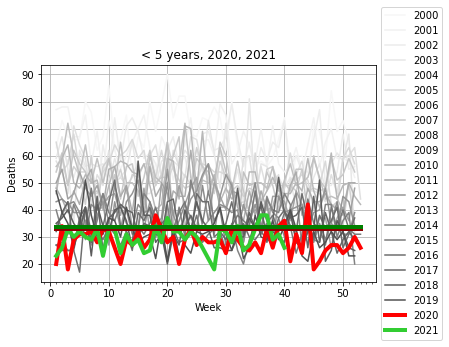

2020: Trend maximally exceeded by 27%
2021: Trend maximally exceeded by 13%
Difference 2020-2021: 27 - 13 = 14 percentage points


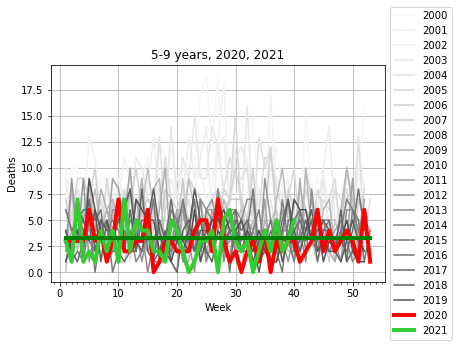

2020: Trend maximally exceeded by 111%
2021: Trend maximally exceeded by 116%
Difference 2020-2021: 111 - 116 = -5 percentage points


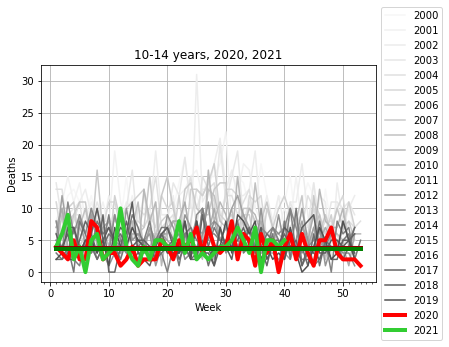

2020: Trend maximally exceeded by 108%
2021: Trend maximally exceeded by 171%
Difference 2020-2021: 108 - 171 = -64 percentage points


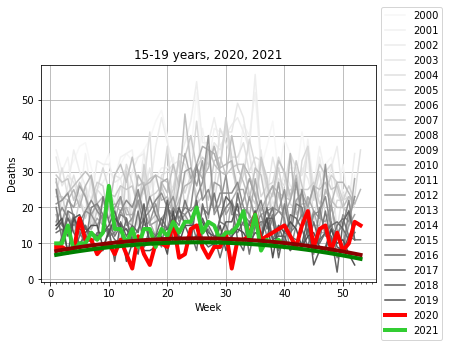

2020: Trend maximally exceeded by 104%
2021: Trend maximally exceeded by 192%
Difference 2020-2021: 104 - 192 = -87 percentage points


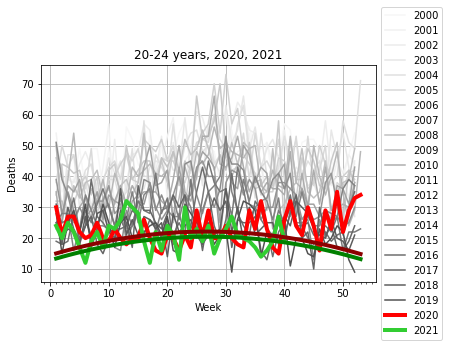

2020: Trend maximally exceeded by 107%
2021: Trend maximally exceeded by 73%
Difference 2020-2021: 107 - 73 = 33 percentage points


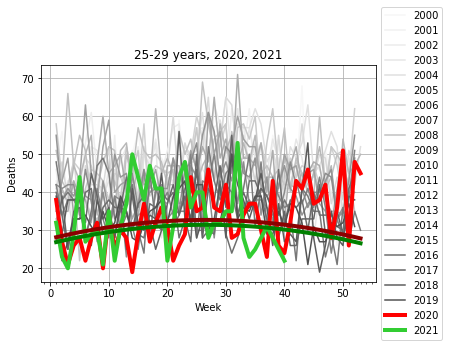

2020: Trend maximally exceeded by 76%
2021: Trend maximally exceeded by 70%
Difference 2020-2021: 76 - 70 = 7 percentage points


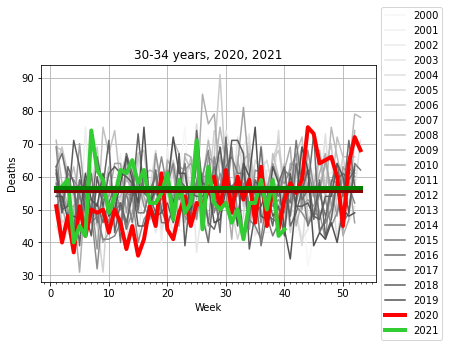

2020: Trend maximally exceeded by 35%
2021: Trend maximally exceeded by 31%
Difference 2020-2021: 35 - 31 = 4 percentage points


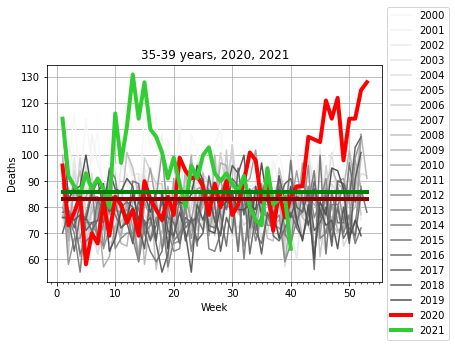

2020: Trend maximally exceeded by 54%
2021: Trend maximally exceeded by 53%
Difference 2020-2021: 54 - 53 = 1 percentage points


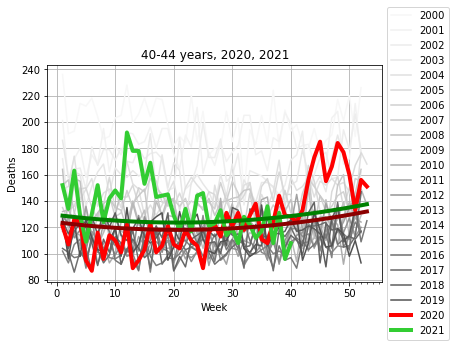

2020: Trend maximally exceeded by 47%
2021: Trend maximally exceeded by 54%
Difference 2020-2021: 47 - 54 = -7 percentage points


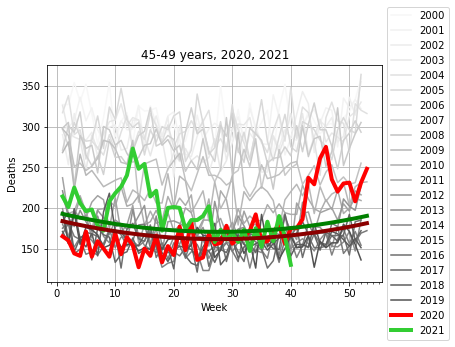

2020: Trend maximally exceeded by 60%
2021: Trend maximally exceeded by 54%
Difference 2020-2021: 60 - 54 = 6 percentage points


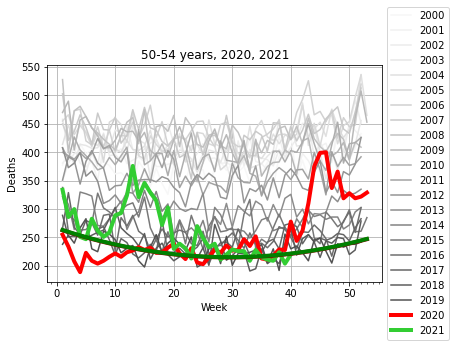

2020: Trend maximally exceeded by 73%
2021: Trend maximally exceeded by 62%
Difference 2020-2021: 73 - 62 = 11 percentage points


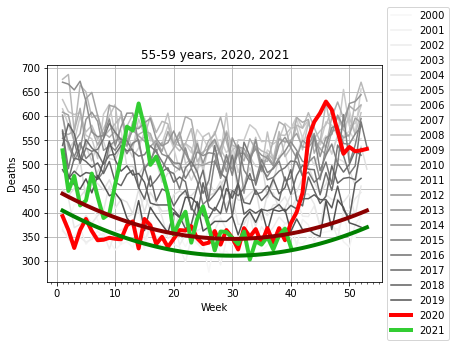

2020: Trend maximally exceeded by 68%
2021: Trend maximally exceeded by 84%
Difference 2020-2021: 68 - 84 = -16 percentage points


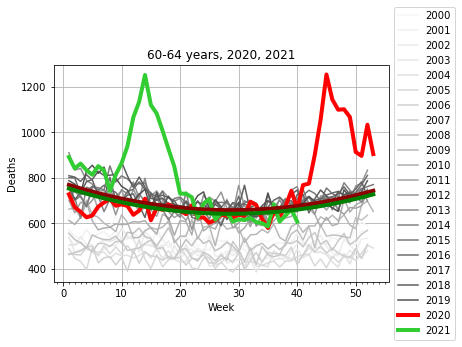

2020: Trend maximally exceeded by 80%
2021: Trend maximally exceeded by 86%
Difference 2020-2021: 80 - 86 = -6 percentage points


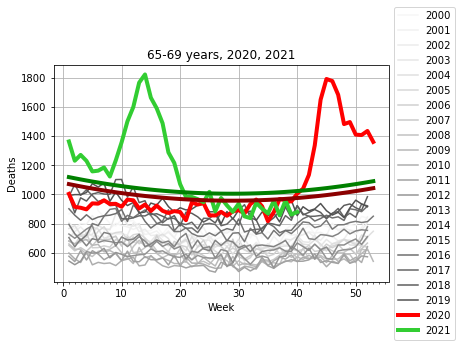

2020: Trend maximally exceeded by 80%
2021: Trend maximally exceeded by 76%
Difference 2020-2021: 80 - 76 = 4 percentage points


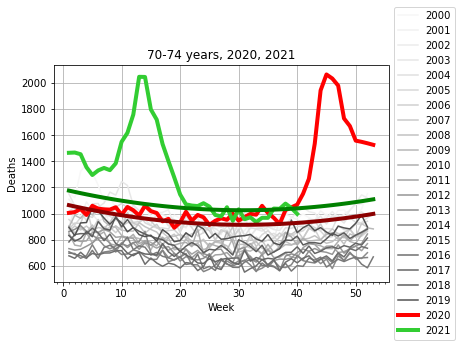

2020: Trend maximally exceeded by 118%
2021: Trend maximally exceeded by 90%
Difference 2020-2021: 118 - 90 = 28 percentage points


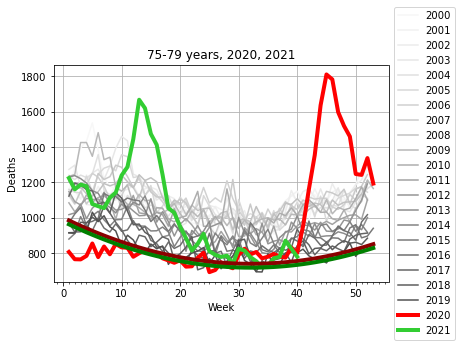

2020: Trend maximally exceeded by 131%
2021: Trend maximally exceeded by 106%
Difference 2020-2021: 131 - 106 = 26 percentage points


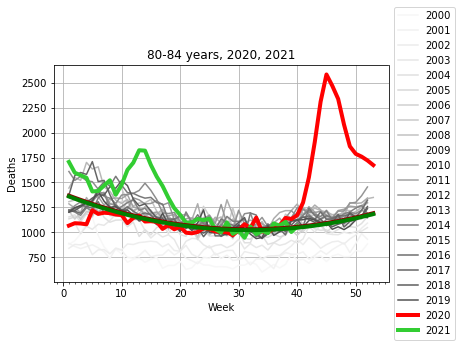

2020: Trend maximally exceeded by 136%
2021: Trend maximally exceeded by 59%
Difference 2020-2021: 136 - 59 = 77 percentage points


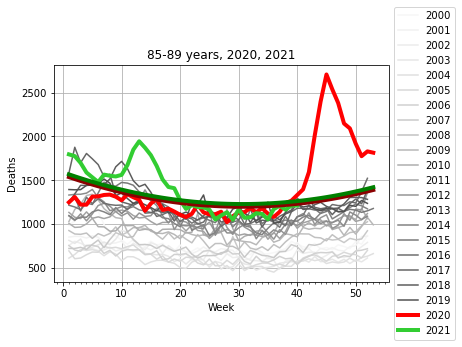

2020: Trend maximally exceeded by 112%
2021: Trend maximally exceeded by 44%
Difference 2020-2021: 112 - 44 = 68 percentage points


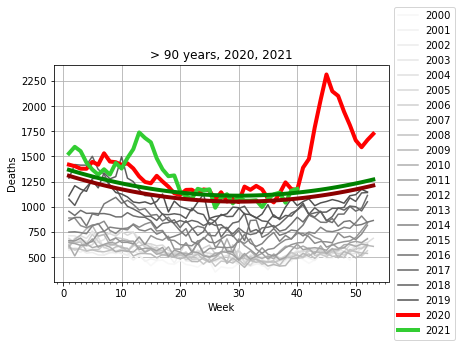

2020: Trend maximally exceeded by 107%
2021: Trend maximally exceeded by 45%
Difference 2020-2021: 107 - 45 = 62 percentage points


In [54]:
def trend_exceeded_ratio(df2, year):
    # https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
    idx = pd.IndexSlice
    column = df2.loc[:,idx[df2.columns[0][0],year]]
    
    column = pd.to_numeric(column)
    trend = [f(year,y, i,dfparams) for y in range(1,54) ]
    dftrend = pd.DataFrame()
    dftrend['Week'] = [y for y in range(1,54) ]
    dftrend['Value'] = trend
    dftrend.set_index('Week', inplace=True)
    
#     display(dftrend)
#     print(column.max())
#     print(column.idxmax())

    trendvalue = dftrend.loc[column.idxmax()]['Value']
#     print(trendvalue)
    trend_exceeded_ratio = (column.max() - trendvalue)/trendvalue
    return trend_exceeded_ratio


tedf2020_2021 = pd.DataFrame(columns=['2020: Trend maximally exceeded by [%]','2021: Trend maximally exceeded by [%]'])

ylims_dict = {}
for i in range(0,95,5):
    trend2020 = [f(2020,y, i,dfparams) for y in range(1,54) ]
    trend2021 = [f(2021,y, i,dfparams) for y in range(1,54) ]
    dftrend = pd.DataFrame()
    dftrend['Week'] = [y for y in range(1,54) ]
    dftrend['Trend 2020'] = trend2020
    dftrend['Trend 2021'] = trend2021
    dftrend.set_index('Week', inplace=True)
#     display(dftrend)

    df1 = df_PL
    df1=group_by_year(df1)
    df1 = select_age_groups_by_range(df1, i,i+5)
    df2 = select_gender(df1, 'T')
    title = age_groups_verbose[i]
    years = [df2.columns[i][1] for i in range(0,len(df2.columns))]
    po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title + ', 2020, 2021', legend = years)
    fig,ylim =  plot_df(df2, po, dftrend=dftrend)
    ylims_dict[i] = ylim
    format = 'svg'
    figname =  age_groups[i] +'_group_2020'+ '.' + format
    fig.savefig(data_dir+'/images/'+figname, format=format, bbox_inches='tight')
#     print(trend_exceeded_ratio(df2, 2020))
#     print(trend_exceeded_ratio(df2, 2021))
    te2020=trend_exceeded_ratio(df2, 2020)*100
    te2021=trend_exceeded_ratio(df2, 2021)*100
    print(f'2020: Trend maximally exceeded by {te2020:.0f}%')
    print(f'2021: Trend maximally exceeded by {te2021:.0f}%')
    tedf2020_2021=tedf2020_2021.append(
        {'2020: Trend maximally exceeded by [%]':te2020,'2021: Trend maximally exceeded by [%]':te2021},
        ignore_index=True
    )
    print(f'Difference 2020-2021: {te2020:.0f} - {te2021:.0f} = {te2020-te2021:.0f} percentage points')

In [55]:
# display(tedf2020_2021)
tedf = pd.concat([tedf2019, tedf2020_2021], axis=1)
display(tedf)

,Age group,2019: Trend maximally exceeded by [%],2020: Trend maximally exceeded by [%],2021: Trend maximally exceeded by [%]
0,Y_LT5,56.164767,27.345205,12.938702
1,Y5-9,165.981797,111.245327,115.804582
2,Y10-14,123.881404,107.680399,171.432298
3,Y15-19,53.332198,104.445458,191.602904
4,Y20-24,36.846873,106.828327,73.409283
5,Y25-29,47.561314,76.363926,69.608210
6,Y30-34,36.621918,34.814751,30.872828
7,Y35-39,39.428378,53.825990,52.686033
8,Y40-44,17.913245,46.865154,54.038130
9,Y45-49,10.277162,60.077378,54.012832


Dla danych ogólnopolskich, na oko rzeczywiście widać dużą różnicę między 2020 i 2021 rokiem dla grup 80+, która jest znacząca, jeśli porównać z 2019 rokiem. Ale tak naprawdę trzeba by narysować przedziały ufności, żeby widać było, co jest zwykłym szumem, a co jest nowe.

Dla danych z Małopolski widać duże różnice także dla młodszych grup wiekowych, ale nie wiem, czy to nie efekt szumu.

In [63]:
# Jakiego typu jest ylim?
# type(ylims_dict[0])

In [64]:
# Walidacja z 2019 rokiem:

In [65]:
# Czy walidację z 2019 rokiem muszę zrobić w osobnym pliku?




# for i in range(0,95,5):
#     trend = [f(2019,y, i,dfparams) for y in range(1,54) ]
#     dftrend = pd.DataFrame()
#     dftrend['Week'] = [y for y in range(1,54) ]
#     dftrend['Trend'] = trend
#     dftrend.set_index('Week', inplace=True)


#     df1 = df_PL
#     df1=group_by_year(df1)
#     df1 = select_age_groups_by_range(df1, i,i+5)
#     df2 = select_gender(df1, 'T')
#     title = age_groups_verbose[i]
#     years = [df2.columns[i][1] for i in range(0,len(df2.columns)-1)]
#     idx = pd.IndexSlice
#     df3 = df2.loc[:,idx[:,years]]
#     po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title+', validation for 2019', legend = years,\
#                      ylim=ylims_dict[i])
#     fig,ylim1 = plot_df(df3, po, dftrend=dftrend)
# #     print(ylim1)
#     format = 'svg'
#     figname = age_groups[i] + '_group_2019'+ '.' + format
#     fig.savefig(data_dir+'/images/'+figname, format=format, bbox_inches='tight')
    
# #     te2019=trend_exceeded_ratio(df2, 2019)*100

# #     print(f'2019: Trend maximally exceeded by {te2019:.0f}%')

In [66]:
# # custom data_dir

# os.system('cd ' + data_dir + ';\
#           mv Y*.png ./images/')

In [67]:
# os.system("./change_png_file_names.sh " + data_dir )

In [68]:
# Dodać skrypty tworzące raport

In [69]:
os.system("./make_pdf.sh " + data_dir )
os.system('cp ./' + data_dir + '/plots_a4_2x4.pdf '+ './'+ data_dir +'/zgony_grupy_wiekowe_raw_' + region_code + '.pdf')

0

**Dorobić aktualne komentarze!**

In [74]:
comments = 'zgony_grupy_wiekowe_komentarz_EN_02.11.2021.pdf'
plots = 'plots_a4_2x4.pdf'
appendix = 'appendix_EN_12.07.2021.pdf'
output = 'zgony_grupy_wiekowe_komentarz_appendix_EN_02.11.2021.pdf'

command = "cp %s %s" % (comments, data_dir)

os.system(command)

command = "cp %s %s" % (appendix, data_dir)

os.system(command)

command = "./merge_comments_plots_appendix.sh %s %s %s %s %s" % (data_dir, comments, plots, appendix, output)

os.system(command)

0

In [71]:
pwd

'/home/ochab/koronawirus_PAN/Zgony'

In [72]:
# Sezonowość może po prostu nie pasować do tej prostej funkcji
# Dodać trend do legendy
# Opisać, na jakiej zasadzie wybierałam funkcję do fitowania, liniową czy kwadratową - gdy błąd był ...

# Na oko, trend jest przekrzywiony, bo minimum sezonowe jest w 30. tygodniu, a nie w 27.
# Albo zmienić dataframe z multiindex na normalną, albo napisać funkcję wybierającą kolumny.
### Dodać do trendu +/- błąd!!!

In [73]:
df2

Y_GE90,T,NR,PL                                               ...       \
Year           2000 2001 2002 2003 2004 2005 2006 2007 2008 2009  ... 2012   
Week                                                              ...        
1               592  585  569  713  620  687  605  590  659  602  ...  665   
2               651  574  596  711  689  642  568  582  640  677  ...  661   
3               719  549  579  681  713  668  592  578  651  719  ...  689   
4               779  582  540  656  686  609  634  560  562  783  ...  633   
5               762  574  547  649  757  622  728  575  572  815  ...  657   
6               640  591  522  647  697  703  658  573  557  710  ...  741   
7               592  522  520  674  593  727  598  621  553  724  ...  759   
8               589  552  543  761  614  733  574  627  567  622  ...  664   
9               584  535  552  725  622  709  555  695  602  624  ...  690   
10              532  566  539  790  597  753  582  685  611  594  ...  647   
11              520  548  519  756  561  717  561  672  557  588  ...  647   
12              471  471  570  750  637  748  609  632  622  511  ...  631   
13              515  519  527  684  559  648  654  602  609  536  ...  701   
14              472  458  599  624  539  637  601  555  633  536  ...  624   
15              414  484  630  594  610  632  579  595  594  531  ...  714   
16              465  468  546  554  581  612  598  557  544  493  ...  683   
17              471  544  513  558  517  621  558  570  524  526  ...  668   
18              435  522  523  512  541  566  535  509  530  509  ...  708   
19              429  443  550  556  539  549  530  526  497  499  ...  581   
20              466  535  538  504  526  542  535  522  523  483  ...  579   
21              427  460  470  514  552  645  474  548  504  501  ...  643   
22              417  474  455  539  501  573  504  480  496  457  ...  552   
23              400  466  488  499  570  523  539  483  530  455  ...  638   
24              441  494  479  509  522  550  591  430  477  496  ...  541   
25              459  492  554  462  506  536  619  484  449  454  ...  587   
26              351  492  452  469  526  530  533  408  471  493  ...  584   
27              404  499  489  489  496  551  541  461  498  547  ...  671   
28              393  515  518  450  515  549  579  453  461  437  ...  559   
29              393  501  460  480  485  459  541  622  441  490  ...  551   
30              441  431  430  501  584  562  562  478  491  449  ...  681   
31              414  457  523  458  441  450  511  423  487  398  ...  615   
32              413  410  418  470  521  417  482  506  466  468  ...  574   
33              448  432  463  524  509  497  479  482  449  478  ...  525   
34              412  436  427  477  497  451  429  433  462  454  ...  593   
35              406  375  459  444  512  460  460  452  452  412  ...  529   
36              417  447  454  471  489  535  444  445  463  427  ...  510   
37              427  454  426  490  479  489  477  470  417  411  ...  544   
38              440  501  466  501  514  502  509  482  495  416  ...  593   
39              494  456  517  506  537  513  487  549  499  487  ...  624   
40              516  574  573  508  551  548  486  516  523  487  ...  641   
41              476  512  499  519  568  554  496  495  499  538  ...  647   
42              438  491  510  557  579  566  565  592  533  508  ...  734   
43              473  467  547  579  574  543  552  516  487  554  ...  697   
44              521  526  529  574  592  576  560  529  541  545  ...  675   
45              486  529  542  526  507  527  546  504  541  548  ...  600   
46              489  566  556  570  534  566  549  560  507  586  ...  620   
47              531  525  554  588  563  529  537  565  514  493  ...  641   
48              532  536  542  554  600  553  520  599  495  556  ...  654   
49              470  581  5